# Notebook for the first baseline model 
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

/opt/anaconda3/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

In [4]:
adata.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,clr_Isotype_RTK2758,clr_Isotype_RTK4530,clr_CCR7,clr_CD62L,clr_CXCR3,clr_CD45RA,log_clone_size,TCR_mean,TCRC_mean,is_dex+
AAACCTGAGTGTTGAA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.065794,1.511381,False
AAACCTGCACCAGGCT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,6164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.088723,1.310205,False
AAACCTGCATACGCTA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,5506.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,0.091682,0.705496,False
AAACGGGAGATGTGGC-1-initial-0-0,True,True,False,[],TRAC,NaN,NaN,NaN,4264.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062257,0.914930,False
AAACGGGGTACGAAAT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,680.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.828641,0.064372,1.095210,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTCTGAGA-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,3450.0,NaN,...,NaN,NaN,0.54596,0.0,0.000000,0.531053,0.000000,0.081136,1.335303,False
TTTGGTTGTTCGGGCT-1-2-1,True,True,False,[],TRAC,NaN,TRBC2,NaN,892.0,NaN,...,NaN,NaN,0.54596,0.0,0.197889,0.287940,1.609438,0.078837,1.086240,False
TTTGGTTTCCACGACG-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,1186.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.360315,6.993933,0.084793,2.290340,False
TTTGTCACAGCTGCAC-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,884.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.569542,6.993933,0.065752,1.288824,False


In [5]:
adata.var

,gene_ids,feature_types-0,genome-0,n_cells-0,feature_types-1,genome-1,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,27,Gene Expression,GRCh38,False,0.000874,1.075864,-1.150517
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,441,Gene Expression,GRCh38,False,0.023432,1.259884,-0.108835
LINC01409,ENSG00000237491,Gene Expression,GRCh38,358,Gene Expression,GRCh38,False,0.020166,1.242911,-0.204914
FAM87B,ENSG00000177757,Gene Expression,GRCh38,71,Gene Expression,GRCh38,False,0.003413,1.224581,-0.308672
LINC01128,ENSG00000228794,Gene Expression,GRCh38,1677,Gene Expression,GRCh38,False,0.097386,1.220801,-0.330072
...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,124,Gene Expression,GRCh38,True,0.006435,1.310383,0.177024
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,490,Gene Expression,GRCh38,False,0.022972,1.222385,-0.321103
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,378,Gene Expression,GRCh38,False,0.020251,1.274951,-0.023547
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,274,Gene Expression,GRCh38,False,0.024502,1.221166,-0.328006


In [5]:
print(adata.obs.donor.cat.categories.values)
print(adata.obs.time.cat.categories.values)
adata.obs[['donor','time','experiment']].head(3)

['A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A11' 'A15' 'A16' 'A19' 'A25'
 'A29' 'HIM']
['P1' 'S1' 'S2' 'S3' 'T1' 'T2' 'T3' 'X3' 'extra']


,donor,time,experiment
AAACCTGAGTGTTGAA-1-initial-0-0,A15,S2,first_experiment
AAACCTGCACCAGGCT-1-initial-0-0,A29,S2,first_experiment
AAACCTGCATACGCTA-1-initial-0-0,A15,S2,first_experiment


# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

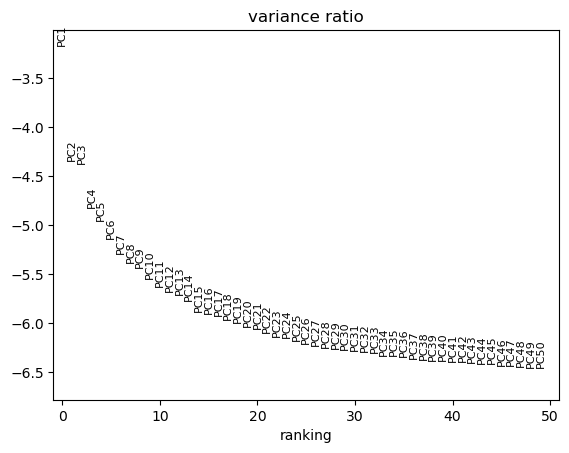

In [6]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

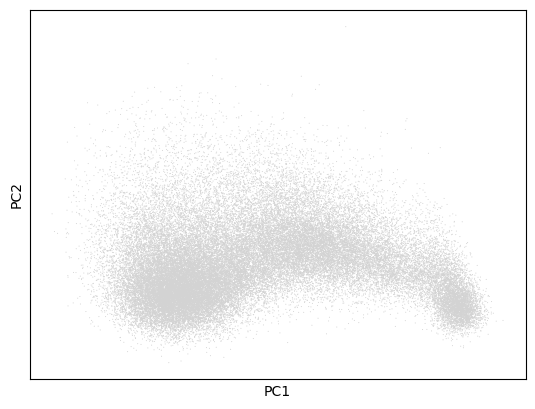

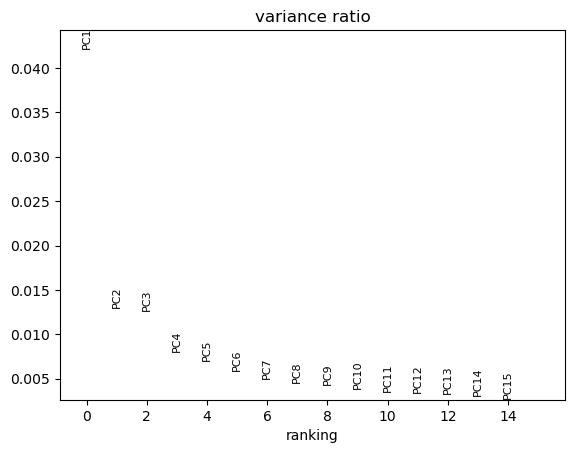

In [7]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [8]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353599  ,  2.2930684 ,  5.475095  , ..., -0.42035165,
        -0.49188307, -0.7464614 ],
       [ 8.438534  , -4.256931  ,  2.3050709 , ...,  2.3662179 ,
         0.58670783, -0.10710645],
       [-3.9699266 ,  9.784491  ,  1.751464  , ...,  2.0638733 ,
         2.7388659 , -2.1804137 ],
       ...,
       [-4.581481  , -1.3408933 ,  1.0974716 , ..., -1.164471  ,
        -1.8378661 , -0.43813595],
       [-3.7005863 , -1.7343283 , -1.1275568 , ..., -1.7393296 ,
         0.7136808 ,  0.39433032],
       [-2.018728  ,  1.920088  , -4.796494  , ...,  0.93350214,
         0.43976098,  0.09896234]], dtype=float32)

In [10]:
sc.pp.neighbors(adata, n_pcs=15, n_neighbors=15) # Compute the neighborhood graph
sc.tl.umap(adata) # Perform UMAP # TODO brauche ich das?????

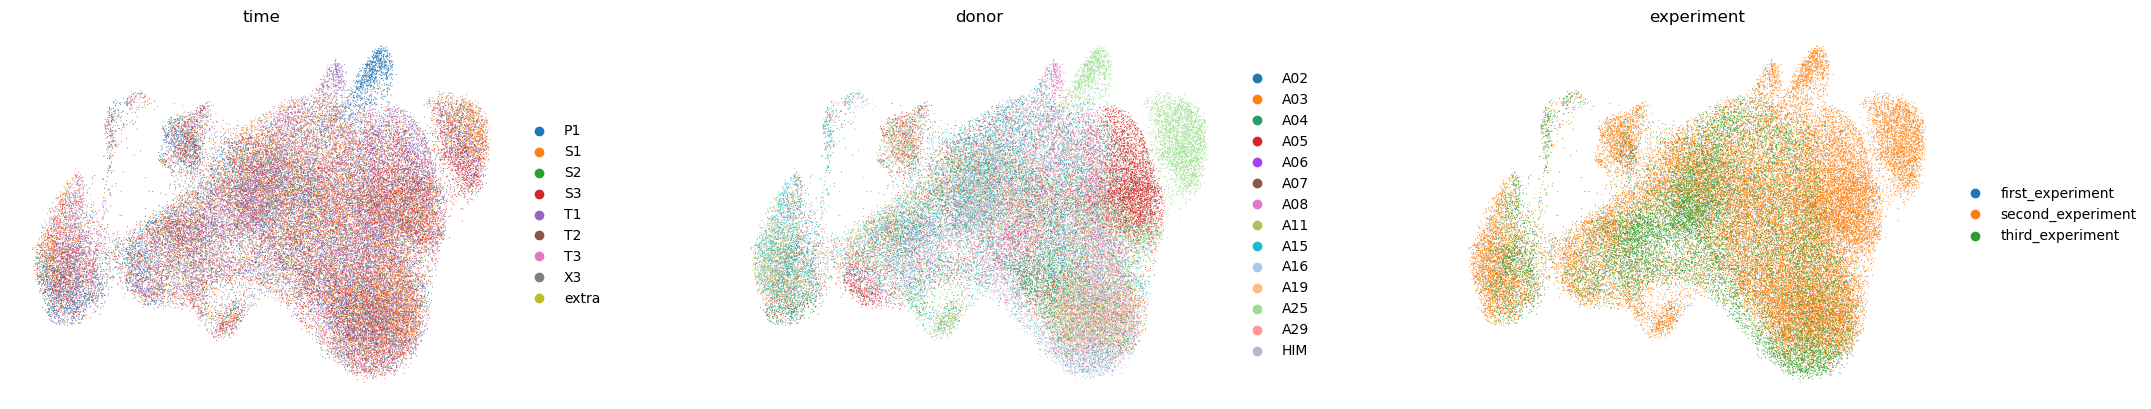

In [11]:
sc.pl.umap(adata, color=['time','donor','experiment'], frameon=False, wspace=0.3, size=2)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [126]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [127]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm["X_pca"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable
P1_clones = adata[P1_mask].obs["clone_id"].values

# Baseline Model with random cell pairing

In [16]:
from sklearn.linear_model import LinearRegression
# alternative: random pairing of cells - baseline model
# Random pairing of cells
random_indices_s1 = np.random.permutation(len(S1_targets))
random_indices_t1 = np.random.permutation(len(T1_targets))

# Shuffle and align S1 and T1 responses with P1 clones randomly
s1_random = S1_targets[random_indices_s1[:len(P1_clones)]]
t1_random = T1_targets[random_indices_t1[:len(P1_clones)]]

# Aggregate features for training
X_aggregated = []
y_s1_aggregated = []
y_t1_aggregated = []

for clone in np.unique(P1_clones):
    mask = P1_clones == clone  # Select rows for the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1_random[mask].mean())  # Randomized S1 response
    y_t1_aggregated.append(t1_random[mask].mean())  # Randomized T1 response

# Convert to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated_baseline = np.array(y_s1_aggregated)
y_t1_aggregated_baseline = np.array(y_t1_aggregated)

# Cell Pairing

## Model with Cell Pairing based on timepoints

In [128]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])
p1 = np.array([cid for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X, s1, t1 = X[valid_indices], s1[valid_indices], t1[valid_indices]
P1_clones = P1_clones[valid_indices]

In [129]:
# get cells per clonotype
clonotype_cell_counts = pd.DataFrame(P1_clones, columns=["Clonotype"]).value_counts().reset_index()
clonotype_cell_counts.columns = ["Clonotype", "Cell Count"]

# Display the counts per clonotype
clonotype_cell_counts.head()

,Clonotype,Cell Count
0,897.0,297
1,926.0,216
2,30.0,160
3,870.0,141
4,171.0,136


In [130]:
adata.obs["clone_id"].value_counts()

clone_id
897.0      2388
30.0       1124
926.0      1090
171.0       995
855.0       747
           ... 
6607.0        1
6608.0        1
6610.0        1
6611.0        1
20300.0       1
Name: count, Length: 12701, dtype: int64

## Cell Pairing based on optimal transport
currently not compatible with the other snippets -> e.g can't use output for train test split based on timepoint

### P1 and S1

In [86]:
import numpy as np
import ot  # Python Optimal Transport library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ot pairing for P1 and S1
# Extract target IFN response scores
y_p1 = adata[P1_mask].obs["IFN Response_score"].values
y_s1 = adata[S1_mask].obs["IFN Response_score"].values

# Extract PCA embeddings and target values
X_p1 = adata[P1_mask].obsm["X_pca"]
X_s1 = adata[S1_mask].obsm["X_pca"]

# Compute cost matrix and solve OT problem
cost_matrix_s1 = ot.dist(X_p1, X_s1, metric='euclidean')
a_s1 = np.ones(len(X_p1)) / len(X_p1)
b_s1 = np.ones(len(X_s1)) / len(X_s1)
transport_plan_s1 = ot.emd(a_s1, b_s1, cost_matrix_s1)

# Extract paired indices
paired_indices_s1 = np.argwhere(transport_plan_s1 > 0)
paired_p1_indices_s1 = paired_indices_s1[:, 0]
paired_t1_indices = paired_indices_s1[:, 1]

# Prepare training data
paired_features_p1_s1 = X_p1[paired_p1_indices_s1]
paired_features_s1 = X_s1[paired_t1_indices]
paired_targets_s1 = y_s1[paired_t1_indices]

X_s1_train = np.hstack([paired_features_p1_s1, paired_features_s1])
y_s1_train = paired_targets_s1 


In [87]:
# get testing dataset - pair the cells by clonotype
# Pair cells by clonotype for the test set
clonotypes_s1 = adata[S1_mask].obs["clone_id"].values
clonotypes_p1 = adata[P1_mask].obs["clone_id"].values
common_clonotypes = np.intersect1d(clonotypes_s1, clonotypes_p1)

test_p1_indices = []
test_s1_indices = []

for clonotype in common_clonotypes:
    p1_clonotype_mask = clonotypes_p1 == clonotype
    s1_clonotype_mask = clonotypes_s1 == clonotype

    # Use the first cell from each clonotype
    test_p1_indices.append(np.where(p1_clonotype_mask)[0][0])
    test_s1_indices.append(np.where(s1_clonotype_mask)[0][0])

test_features_p1 = X_p1[test_p1_indices]
test_features_s1 = X_s1[test_s1_indices]
test_targets_s1 = y_s1[test_s1_indices]

X_s1_test = np.hstack([test_features_p1, test_features_s1])
y_s1_test = test_targets_s1

In [101]:
# Train the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#model = LinearRegression()
model.fit(X_s1_train, y_s1_train)

# Test the model
y_s1_pred = model.predict(X_s1_test)

In [102]:
mse_s1_ot = mean_squared_error(y_s1_test, y_s1_pred)
recall_ks1 = recall_at_k(y_s1_test, y_s1_pred, 5)
"""recall_kt1_ot = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    5
)"""
mean_clonotype_activation_s1_predicted_ot = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1_ot = y_s1_test.mean()# True mean clonotype activation for the test set



print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE for S1: {mse_s1_ot}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1_ot:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted_ot:.4f}")

Recall@5 for S1: 0.60
MSE for S1: 0.009823508437373242
Mean Clonotype Activation (S1): -0.0373
Mean Clonotype Activation (S1) Predicted: -0.0398


### P1 and T1

In [91]:
# OT Pairing for T1 and P1
# Extract target IFN response scores for T1
y_t1 = adata[T1_mask].obs["IFN Response_score"].values
y_p1 = adata[P1_mask].obs["IFN Response_score"].values

# Extract PCA embeddings and target values
X_p1 = adata[P1_mask].obsm["X_pca"]
X_t1 = adata[T1_mask].obsm["X_pca"]

# Compute cost matrix and solve OT problem
cost_matrix_t1 = ot.dist(X_p1, X_t1, metric='euclidean')
a_t1 = np.ones(len(X_p1)) / len(X_p1)
b_t1 = np.ones(len(X_t1)) / len(X_t1)
transport_plan_t1 = ot.emd(a_t1, b_t1, cost_matrix_t1)

# Extract paired indices
paired_indices_t1 = np.argwhere(transport_plan_t1 > 0)
paired_p1_indices_t1 = paired_indices_t1[:, 0]
paired_t1_indices = paired_indices_t1[:, 1]

# Prepare training data
paired_features_p1_t1 = X_p1[paired_p1_indices_t1]
paired_features_t1 = X_t1[paired_t1_indices]
paired_targets_t1 = y_t1[paired_t1_indices]

X_t1_train = np.hstack([paired_features_p1_t1, paired_features_t1])
y_t1_train = paired_targets_t1 


In [92]:
# get testing dataset - pair the cells by clonotype
# Pair cells by clonotype for the test set
clonotypes_t1 = adata[T1_mask].obs["clone_id"].values
clonotypes_p1 = adata[P1_mask].obs["clone_id"].values
common_clonotypes = np.intersect1d(clonotypes_t1, clonotypes_p1)

test_p1_indices = []
test_t1_indices = []

for clonotype in common_clonotypes:
    p1_clonotype_mask = clonotypes_p1 == clonotype
    t1_clonotype_mask = clonotypes_t1 == clonotype

    # Use the first cell from each clonotype
    test_p1_indices.append(np.where(p1_clonotype_mask)[0][0])
    test_t1_indices.append(np.where(t1_clonotype_mask)[0][0])

test_features_p1 = X_p1[test_p1_indices]
test_features_t1 = X_t1[test_t1_indices]
test_targets_t1 = y_t1[test_t1_indices]

X_t1_test = np.hstack([test_features_p1, test_features_t1])
y_t1_test = test_targets_t1


In [103]:
# Train the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#model = LinearRegression()
model.fit(X_t1_train, y_t1_train)

# Test the model
y_t1_pred = model.predict(X_t1_test)

In [104]:
mse_t1_ot = mean_squared_error(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred, 5)
"""recall_kt1_ot = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    5
)"""
mean_clonotype_activation_t1_predicted_ot = y_t1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_t1_ot = y_t1_test.mean()# True mean clonotype activation for the test set



print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE for T1: {mse_t1_ot}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1_ot:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted_ot:.4f}")

Recall@5 for T1: 0.60
MSE for T1: 0.01168031235003354
Mean Clonotype Activation (T1): 0.0799
Mean Clonotype Activation (T1) Predicted: 0.0794


### Eval and Explore

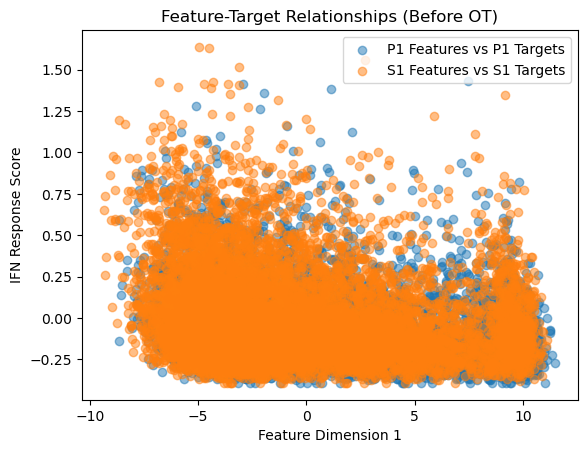

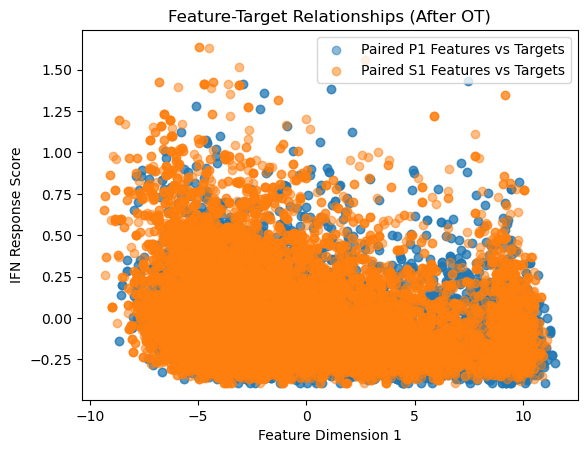

In [19]:
# Scatter plot of original features vs targets (no OT pairing)
plt.scatter(X_p1[:, 0], y_p1, alpha=0.5, label="P1 Features vs P1 Targets")
plt.scatter(X_s1[:, 0], y_s1, alpha=0.5, label="S1 Features vs S1 Targets")
plt.xlabel("Feature Dimension 1")
plt.ylabel("IFN Response Score")
plt.title("Feature-Target Relationships (Before OT)")
plt.legend()
plt.show()

# Scatter plot of paired features (after OT) vs targets
plt.scatter(paired_features_p1[:, 0], paired_targets_p1, alpha=0.5, label="Paired P1 Features vs Targets")
plt.scatter(paired_features_s1[:, 0], paired_targets_s1, alpha=0.5, label="Paired S1 Features vs Targets")
plt.xlabel("Feature Dimension 1")
plt.ylabel("IFN Response Score")
plt.title("Feature-Target Relationships (After OT)")
plt.legend()
plt.show()


In [20]:
"""# Split data into training and testing sets
#X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_regression, y_s1_regression, test_size=0.2, random_state=42)
X_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(X_regression_t1, y_regression_t1, test_size=0.2, random_state=42)

# Initialize and train the model
#model = LinearRegression()
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#model.fit(X_s1_train, y_s1_train)
model.fit(X_t1_train, y_t1_train)


# Predict on the test set
#y_s1_pred = model.predict(X_s1_test)
y_t1_pred = model.predict(X_t1_test)"""

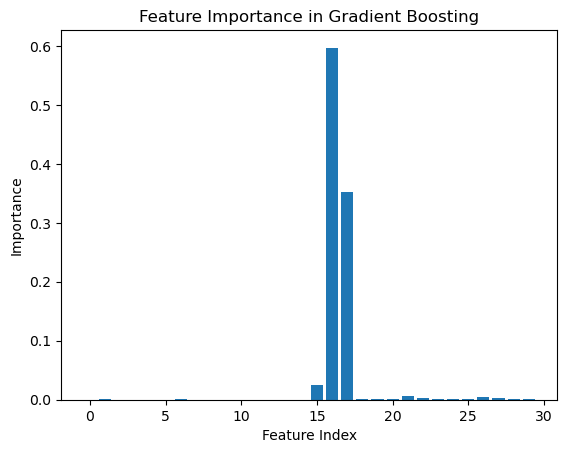

In [21]:
# Plot feature importances
importances = model.feature_importances_
num_features = len(importances)

plt.bar(range(num_features), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance in Gradient Boosting")
plt.show()

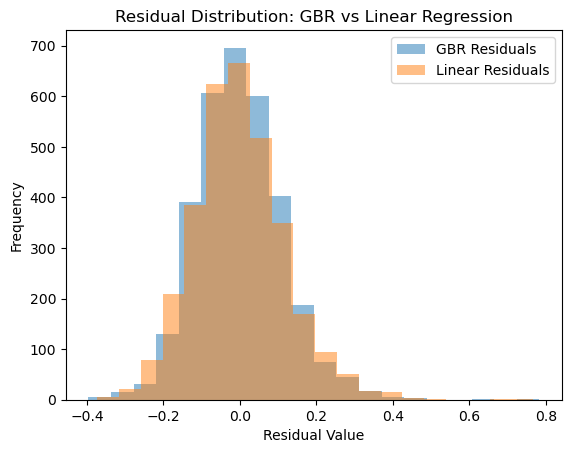

GBR MSE: 0.0127
Linear Regression MSE: 0.0142


In [22]:
# Compute residuals for GBR
gbr_residuals = y_t1_test - y_t1_pred

# Train a Linear Regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X_t1_train, y_t1_train)
y_t1_linear_pred = linear_model.predict(X_t1_test)

# Compute residuals for Linear Regression
linear_residuals = y_t1_test - y_t1_linear_pred

# Plot residuals
plt.hist(gbr_residuals, bins=20, alpha=0.5, label="GBR Residuals")
plt.hist(linear_residuals, bins=20, alpha=0.5, label="Linear Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution: GBR vs Linear Regression")
plt.legend()
plt.show()

# Calculate residual statistics
gbr_mse = mean_squared_error(y_t1_test, y_t1_pred)
linear_mse = mean_squared_error(y_t1_test, y_t1_linear_pred)

print(f"GBR MSE: {gbr_mse:.4f}")
print(f"Linear Regression MSE: {linear_mse:.4f}")


In [82]:
k = 5

"""# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
recall_ks1 = recall_at_k(y_s1_test, y_s1_pred, k)
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set


print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE for S1: {mse_s1}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")"""

# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred, k)
#ms2_t1_gbr = mean_squared_error(y_t1_test, y_t1_pred_gbr)
mean_clonotype_activation_t1 = y_t1_test.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE for T1: {mse_t1}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")

"""
# Plot predictions vs actual values
plt.scatter(y_s1_test, y_s1_pred, alpha=0.7)
plt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], 'r--')
plt.xlabel("Actual IFN Response")
plt.ylabel("Predicted IFN Response")
plt.title("Actual vs Predicted IFN Response")
plt.show()"""

Recall@5 for T1: 0.20
MSE for T1: 0.11278247181488796
Mean Clonotype Activation (T1): 0.0530


'\n# Plot predictions vs actual values\nplt.scatter(y_s1_test, y_s1_pred, alpha=0.7)\nplt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], \'r--\')\nplt.xlabel("Actual IFN Response")\nplt.ylabel("Predicted IFN Response")\nplt.title("Actual vs Predicted IFN Response")\nplt.show()'

### Alternative: cellpairing based on optimal transport using moscot library

In [36]:
import numpy as np
import scanpy as sc
import moscot
from moscot.problems.time import TemporalProblem
#from moscot.plotting import plot_transport_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Define the OT problem
problem = TemporalProblem(adata)

# Convert time categories to numeric
adata.obs['time_encoded'] = adata.obs['time'].cat.codes

# Prepare the problem: Ensure timepoints are in .obs["time"]
problem = problem.prepare(
    time_key="time_encoded",
    policy="sequential",  # Specify transport policy (e.g., sequential or full)
    cost="sq_euclidean",  # Use Euclidean distance for cost
    xy={"X_pca": "X_pca"}  # Use PCA embeddings stored in .obsm["X_pca"]
)

# Solve the OT problem
problem = problem.solve(
    epsilon=0.01,  # Entropic regularization parameter
    lse_mode=True,  # Use log-sum-exp mode if supported
    max_iterations=1000  # Maximum iterations for convergence
)


INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Solving `6` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(8451, 10470)].                                 
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1047

AttributeError: 'TemporalProblem' object has no attribute 'get_transport_matrix'

In [48]:
# Retrieve the transport matrix
matrix = problem.solutions[(0, 1)]

# Extract the actual transport matrix
if hasattr(matrix, "matrix"):
    transport_matrix = matrix.matrix
elif hasattr(matrix, "to_numpy"):
    transport_matrix = matrix.to_numpy()
elif hasattr(matrix, "toarray"):
    transport_matrix = matrix.toarray()
else:
    raise AttributeError("Unable to retrieve transport matrix from OTTOutput object.")

# Validate the transport matrix
print("Transport matrix type:", type(transport_matrix))
print("Transport matrix shape:", transport_matrix.shape)

# Ensure the transport matrix is 2D
if len(transport_matrix.shape) < 2:
    raise ValueError("Transport matrix is not a 2D array. Check OT computation.")

# Extract paired indices
paired_indices = np.argwhere(transport_matrix > 0)
source_indices = paired_indices[:, 0]
target_indices = paired_indices[:, 1]

# Extract paired features and targets
paired_features_p1 = adata[P1_mask].obsm["X_pca"][source_indices]
paired_features_s1 = adata[S1_mask].obsm["X_pca"][target_indices]
paired_targets_s1 = adata[S1_mask].obs["IFN Response_score"].values[target_indices]

# Combine paired features
X_regression = np.hstack([paired_features_p1, paired_features_s1])
y_regression = paired_targets_s1



AttributeError: Unable to retrieve transport matrix from OTTOutput object.

In [ ]:
# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Step 6: Train a Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")

# Step 8: Visualize the transport matrix
plt.imshow(transport_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Transport Probability")
plt.xlabel("S1 Cells")
plt.ylabel("P1 Cells")
plt.title("Optimal Transport Matrix")
plt.show()

## Split into Train-Val-Test

 The splitting is done based on the unique clonotypes (unique_clonotypes_aggregated) to ensure that clones seen in the training set are not present in the test set. Here, a 80-20 split is used.

 Possible options to avoid biases:
 - split to maintain the distribution of responses in both train and test sets
 - additionally divide based on donor or experiment


### Split by Timepoint

In [110]:
from sklearn.model_selection import train_test_split

# Extract unique clonotypes from P1
unique_clonotypes_aggregated = np.unique(P1_clones) 

# Train-test split by optimal transport aggregation
train_clonotypes, test_clonotypes  = train_test_split(unique_clonotypes_aggregated, test_size=0.2, random_state=42)

# Create masks for train and test sets based on the asigned clonotypes
train_mask = np.isin(unique_clonotypes_aggregated, train_clonotypes)
test_mask = np.isin(unique_clonotypes_aggregated, test_clonotypes)

# Recreate aggregated arrays aligned with unique clonotypes
X_aggregated = []  # features
y_s1_aggregated = [] # target values for s1
y_t1_aggregated = []
test_s1_clonotypes = []
test_t1_clonotypes = []


# Aggregate features and targets by clone
for clone in unique_clonotypes_aggregated:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1[mask].mean())      # Mean of s1 for the clone
    y_t1_aggregated.append(t1[mask].mean())      # Mean of t1 for the clone
    if s1[mask] is not np.nan:
        test_s1_clonotypes.append(clone)             # Save the clonotype for test set
    elif t1[mask] is not np.nan:
        test_t1_clonotypes.append(clone)             # Save the clonotype for test set


# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)


# Split aggregated data into train and test sets
X_s1_train, X_s1_test = X_aggregated[train_mask], X_aggregated[test_mask]
X_t1_train, X_t1_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]

### Alternative: Split- by Donor

In [131]:
from sklearn.model_selection import train_test_split
import numpy as np

# Extract donor information and unique clonotypes
donors = adata.obs["donor"].values  # Donor IDs for each cell
unique_clonotypes = np.unique(P1_clones)  # Unique clonotypes in P1

# Map each clonotype to a donor
clonotype_to_donor = {clone: donors[np.where(P1_clones == clone)[0][0]] for clone in unique_clonotypes}

# Extract unique donors
unique_donors = np.unique(list(clonotype_to_donor.values()))

# Split donors into train and test
train_donors, test_donors = train_test_split(unique_donors, test_size=0.2, random_state=42)

# Create masks for train and test clonotypes based on donors
train_clonotypes = [clone for clone, donor in clonotype_to_donor.items() if donor in train_donors]
test_clonotypes = [clone for clone, donor in clonotype_to_donor.items() if donor in test_donors]

# Aggregate features and targets by clone
X_aggregated = []  # Features
y_s1_aggregated = []  # Target values for S1
y_t1_aggregated = []  # Target values for T1
y_p1_aggregated = []  # Target values for P1

for clone in unique_clonotypes:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    # y_p1_aggregated.append(p1[mask].mean())   # Mean of P1 for the clone
    y_s1_aggregated.append(s1[mask].mean())   # Mean of S1 for the clone
    y_t1_aggregated.append(t1[mask].mean())   # Mean of T1 for the clone

# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)

# Create masks for train and test sets
train_mask = np.isin(unique_clonotypes, train_clonotypes)
test_mask = np.isin(unique_clonotypes, test_clonotypes)

# Split aggregated data into train and test sets
X_s1_train, X_s1_test = X_aggregated[train_mask], X_aggregated[test_mask]
X_t1_train, X_t1_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]



## Train Models
For the first baseline model, a Linear Regression is used, since our goal is to predict a numerical and continuous output value  (=IFN score) based on the input features. One can furthermore tune the parameters to improve this model. 

Possible Arcitectures for future models:
- RandomForest
- SVMs
- NNs

### Baseline model

In [26]:
# Train-test split (using sklearn's train_test_split)
from sklearn.model_selection import train_test_split

X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(
    X_aggregated, y_s1_aggregated_baseline, test_size=0.2, random_state=42
)

X_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(
    X_aggregated, y_t1_aggregated_baseline, test_size=0.2, random_state=42
)

# Train baseline model to predict S1 response
baseline_model_s1 = LinearRegression()
baseline_model_s1.fit(X_s1_train, y_s1_train)

# Predict S1 response
y_s1_pred_baseline = baseline_model_s1.predict(X_s1_test)
y_t1_pred_baseline = baseline_model_s1.predict(X_t1_test)

In [30]:
# True mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()
mean_clonotype_activation_t1 = y_t1_test.mean()

mean_clonotype_activation_s1_pred = y_s1_pred_baseline.mean()
mean_clonotype_activation_t1_pred = y_t1_pred_baseline.mean()

# Evaluate model predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred_baseline)
k= 5
recall_ks1 = recall_at_k(y_s1_test, y_s1_pred_baseline, k)

mse_t1 = mean_squared_error(y_t1_test, y_t1_pred_baseline)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred_baseline,  k)

baseline_performance_s1 = f"MSE for S1 Baseline Model: {mse_s1:.4f}\nMean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}\nRecall@{k} for S1: {recall_ks1:.2f}"
print(baseline_performance_s1)

baseline_performance_t1 = f"MSE for T1 Baseline Model: {mse_t1:.4f}\nMean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}\nRecall@{k} for T1: {recall_kt1:.2f}"
print(baseline_performance_t1)

MSE for S1 Baseline Model: 0.0621
Mean Clonotype Activation (S1): -0.0155
Recall@5 for S1: 0.00
MSE for T1 Baseline Model: 0.1106
Mean Clonotype Activation (T1): 0.0776
Recall@5 for T1: 0.00


### Linear Regression

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train a model for S1 using Linear Regression
model_s1 = LinearRegression()
model_s1.fit(X_s1_train, y_s1_train)
y_s1_pred = model_s1.predict(X_s1_test)

# Train a model for T1 using Linear Regression
model_t1 = LinearRegression()
model_t1.fit(X_s1_train, y_t1_train)
y_t1_pred = model_t1.predict(X_t1_test)

### Gradient BoostingRegressor

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
# Initialize and train the Gradient Boosting Regressor
gbr_s1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_s1.fit(X_s1_train, y_s1_train)
y_s1_pred = gbr_s1.predict(X_s1_test)


gbr_t1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_t1.fit(X_s1_train, y_t1_train)
y_t1_pred = gbr_t1.predict(X_t1_test)

# Evaluate Predictions
Calculated mse, recall at k, mean on the activated clonotypes to evaluate the correctness of the predictions

In [49]:
import numpy as np

def recall_at_k(y_true, y_pred, k):
    # Get the indices of the top-k predicted scores
    top_k_pred_indices = np.argsort(y_pred)[-k:]  # Indices of top-k predicted scores
    # Get the indices of the top-k true scores
    top_k_true_indices = np.argsort(y_true)[-k:]  # Indices of top-k true scores

    # Compute intersection of predicted and true top-k indices
    intersection = np.intersect1d(top_k_pred_indices, top_k_true_indices)

    # Compute Recall@k
    recall_k = len(intersection) / k
    return recall_k


In [50]:
def aggregate_responses_by_clonotype(y, clonotype_labels):
    """
    Aggregate responses by clonotype.

    Args:
        y (array-like): Responses (true or predicted) for each cell.
        clonotype_labels (array-like): Clonotype labels for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its average response.
    """
    y = np.array(y)
    clonotype_labels = np.array(clonotype_labels)
    unique_clonotypes = np.unique(clonotype_labels)

    clonotype_avg_responses = {}
    for clonotype in unique_clonotypes:
        # Identify cells belonging to this clonotype
        clonotype_mask = clonotype_labels == clonotype
        # Compute the average response for this clonotype
        clonotype_avg_responses[clonotype] = np.mean(y[clonotype_mask])

    return clonotype_avg_responses

In [53]:
def recall_at_k_clonotype(y_true, y_pred, k):
    """
    Compute recall at K based on clonotype-level responsiveness.

    Args:
        y_true (array-like): True responses for each cell.
        y_pred (array-like): Predicted responses for each cell.
        clonotype_labels (array-like): Clonotype labels for each cell.
        k (int): Number of top clonotypes to consider.

    Returns:
        float: Recall at K based on clonotypes.

        
    """

    clonotype_labels = unique_clonotypes_aggregated[test_mask]
    
    # Aggregate responses by clonotype
    true_responses_by_clonotype = aggregate_responses_by_clonotype(y_true, clonotype_labels)
    pred_responses_by_clonotype = aggregate_responses_by_clonotype(y_pred, clonotype_labels)

    # Sort clonotypes by their average true and predicted responses
    top_k_true_clonotypes = sorted(
        true_responses_by_clonotype, key=true_responses_by_clonotype.get, reverse=True
    )[:k]
    top_k_pred_clonotypes = sorted(
        pred_responses_by_clonotype, key=pred_responses_by_clonotype.get, reverse=True
    )[:k]

    # Compute the intersection of top-k true and predicted clonotypes
    intersection = set(top_k_true_clonotypes) & set(top_k_pred_clonotypes)

    # Compute Recall@K
    recall_k = len(intersection) / k
    return recall_k

In [75]:
k = 5

# Evaluate S1 predictions

mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
recall_ks1 = recall_at_k_clonotype(
    y_s1_test,
    y_s1_pred,
    k
)
mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set



print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE for S1: {mse_s1}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")

# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    k
)
#ms2_t1_gbr = mean_squared_error(y_t1_test, y_t1_pred_gbr)
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE for T1: {mse_t1}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")


Recall@5 for S1: 0.20
MSE for S1: 0.03728919136126611
Mean Clonotype Activation (S1): -0.0941
Mean Clonotype Activation (S1) Predicted: -0.0354
Recall@5 for T1: 0.20
MSE for T1: 0.11278247181488796
Mean Clonotype Activation (T1): 0.0530
Mean Clonotype Activation (T1) Predicted: 0.1270


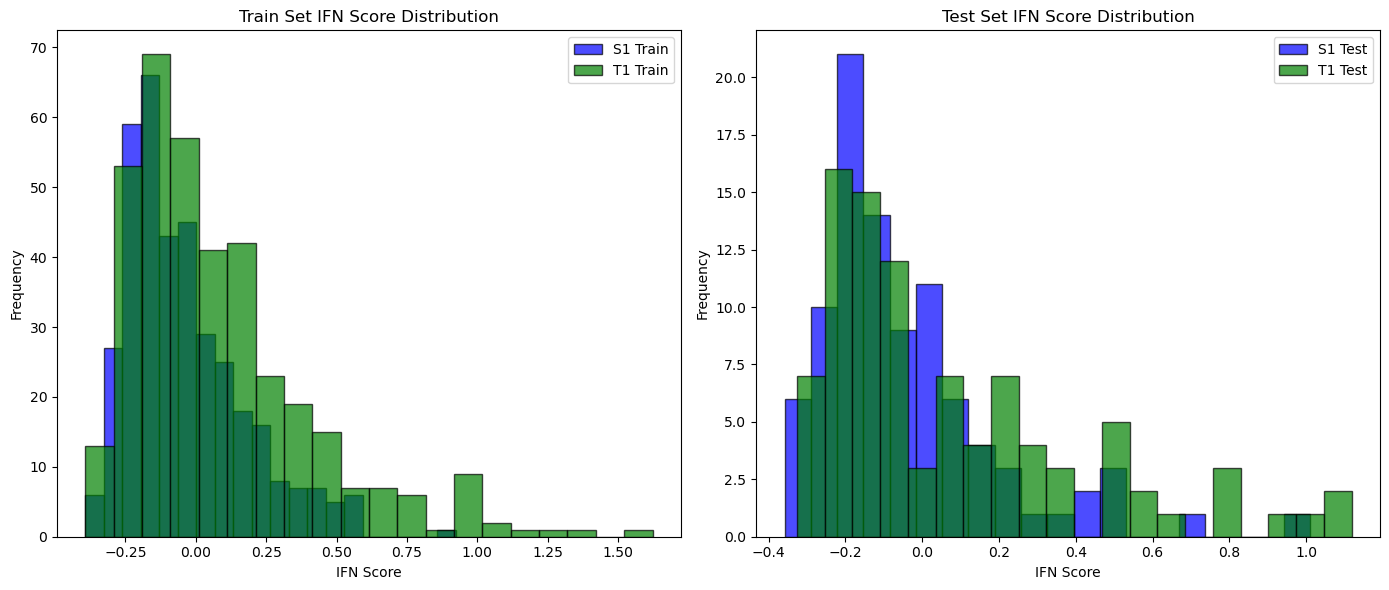

In [74]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="green", edgecolor="black")
plt.title("Train Set IFN Score Distribution")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("Test Set IFN Score Distribution")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

## Explore Results

Focussing on the most active clones 

In [20]:
# Creating a DataFrame with clone IDs, true scores, and predictions
results_df = pd.DataFrame({
    "Clone_ID": unique_clonotypes_aggregated[test_mask],  # Clonotypes in the test set
    "True_S1_Score": y_s1_test,  # True target values for S1
    "Predicted_S1_Score": model_s1.predict(X_s1_test),  # Predicted values for S1
    "True_T1_Score": y_t1_test,  # True target values for T1
    "Predicted_T1_Score": model_s1.predict(X_t1_test)  # Predicted values for T1
})


In [21]:
# Aggregate scores by clone
clone_summary = results_df.groupby("Clone_ID").agg(
    Mean_True_S1_Score=("True_S1_Score", "mean"),
    Mean_Predicted_S1_Score=("Predicted_S1_Score", "mean"),
    Mean_True_T1_Score=("True_T1_Score", "mean"),
    Mean_Predicted_T1_Score=("Predicted_T1_Score", "mean")
).reset_index()

# Sort clones by highest predicted scores for S1 or T1
top_clones = clone_summary.sort_values(by="Mean_Predicted_S1_Score", ascending=False).head(30)
print(top_clones)


   Clone_ID  Mean_True_S1_Score  Mean_Predicted_S1_Score  Mean_True_T1_Score  \
37  18174.0           -0.162282                 0.103617           -0.047664   
40  18339.0            0.006996                 0.095805           -0.326333   
59    359.0           -0.121326                 0.081861            0.560592   
38  18277.0           -0.313058                 0.078013           -0.225398   
10  12157.0            0.036488                 0.070148            1.117963   
34  17933.0           -0.061935                 0.066915            0.188739   
36  18004.0           -0.038618                 0.041568           -0.073127   
31  17882.0            0.188243                 0.036146           -0.220140   
39  18281.0            0.110276                 0.033533            0.245320   
28  17861.0            0.181669                 0.032060            0.132995   

    Mean_Predicted_T1_Score  
37                 0.103617  
40                 0.095805  
59                 0.081861  

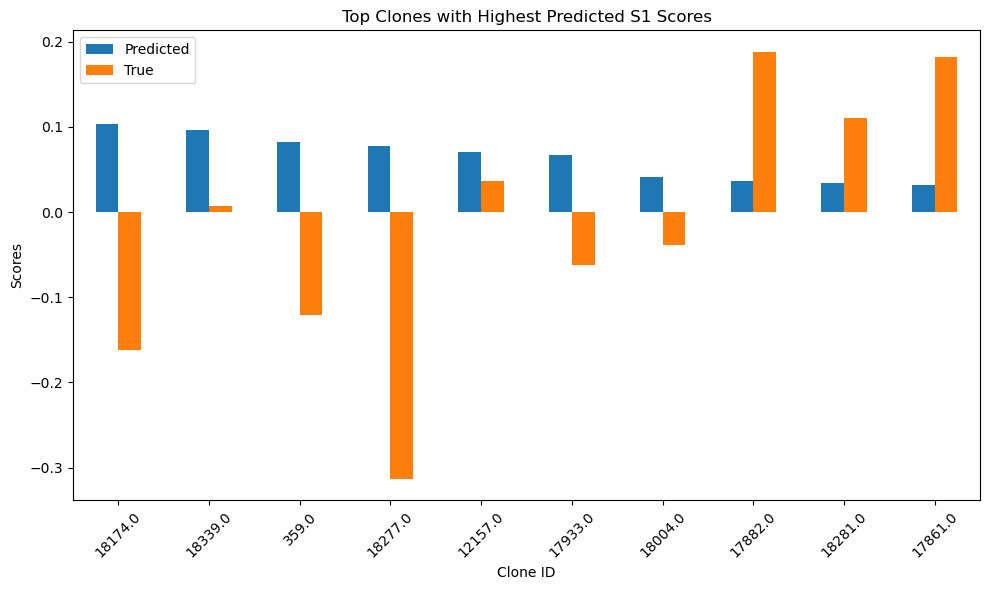

In [22]:
# Bar plot for top clones
top_clones.plot(
    x="Clone_ID",
    y=["Mean_Predicted_S1_Score", "Mean_True_S1_Score"],
    kind="bar",
    figsize=(10, 6),
    title="Top Clones with Highest Predicted S1 Scores"
)
plt.ylabel("Scores")
plt.xlabel("Clone ID")
plt.xticks(rotation=45)
plt.legend(["Predicted", "True"])
plt.tight_layout()
plt.show()


In [23]:
# investigating clone with top scores
top_clone_ids = top_clones["Clone_ID"].values
top_clone_metadata = adata.obs.loc[adata.obs["clone_id"].isin(top_clone_ids)]
print(top_clone_metadata)


                                     is_cell high_confidence multi_chain  \
CCTTACGCAACTGCTA-1-initial-0-0          True            True       False   
GTTTCTAAGGATATAC-1-initial-0-0          True            True       False   
AGATTGCAGCGAAGGG-1-first_shot_10-1-0    True            True       False   
CTTACCGTCTCGCATC-1-first_shot_10-1-0    True            True       False   
TCACAAGAGCGTTTAC-1-first_shot_10-1-0    True            True       False   
...                                      ...             ...         ...   
TTTGGTTCACCGAATT-1-1-1                  True            True       False   
TTTGGTTCATTGAGCT-1-1-1                  True            True       False   
TTTGTCATCTATGTGG-1-1-1                  True            True       False   
CATCAAGTCGTTACAG-1-2-1                  True            True       False   
GTGTTAGTCTAGAGTC-1-2-1                  True            True       False   

                                     extra_chains IR_VJ_1_c_call  \
CCTTACGCAACTGCTA-1-

In [24]:
# Compute MSE for top clones
top_clones_mse = mean_squared_error(
    top_clones["Mean_True_S1_Score"], top_clones["Mean_Predicted_S1_Score"]
)
print(f"Mean Squared Error for Top Clones (S1): {top_clones_mse:.4f}")

Mean Squared Error for Top Clones (S1): 0.0348


### Using only the top highest score per clone

In [26]:
# Create a DataFrame with clone IDs, true scores, and predictions
results_df = pd.DataFrame({
    "Clone_ID": unique_clonotypes_aggregated[test_mask],  # Clonotypes in the test set
    "True_S1_Score": y_s1_test,  # True target values for S1
    "Predicted_S1_Score": model_s1.predict(X_s1_test),  # Predicted values for S1
    "True_T1_Score": y_t1_test,  # True target values for T1
    "Predicted_T1_Score": model_s1.predict(X_t1_test)  # Predicted values for T1
})


In [27]:
# Select the highest predicted score for each clone
top_scores_per_clone = results_df.groupby("Clone_ID").agg(
    Max_True_S1_Score=("True_S1_Score", "max"),
    Max_Predicted_S1_Score=("Predicted_S1_Score", "max"),
    Max_True_T1_Score=("True_T1_Score", "max"),
    Max_Predicted_T1_Score=("Predicted_T1_Score", "max")
).reset_index()

# Sort by the highest predicted S1 scores
top_scores_per_clone = top_scores_per_clone.sort_values(by="Max_Predicted_S1_Score", ascending=False)


In [28]:
# Select the top 10 clones
top_clones = top_scores_per_clone.head(10)
print(top_clones)


   Clone_ID  Max_True_S1_Score  Max_Predicted_S1_Score  Max_True_T1_Score  \
37  18174.0          -0.162282                0.103617          -0.047664   
40  18339.0           0.006996                0.095805          -0.326333   
59    359.0          -0.121326                0.081861           0.560592   
38  18277.0          -0.313058                0.078013          -0.225398   
10  12157.0           0.036488                0.070148           1.117963   
34  17933.0          -0.061935                0.066915           0.188739   
36  18004.0          -0.038618                0.041568          -0.073127   
31  17882.0           0.188243                0.036146          -0.220140   
39  18281.0           0.110276                0.033533           0.245320   
28  17861.0           0.181669                0.032060           0.132995   

    Max_Predicted_T1_Score  
37                0.103617  
40                0.095805  
59                0.081861  
38                0.078013  
10     

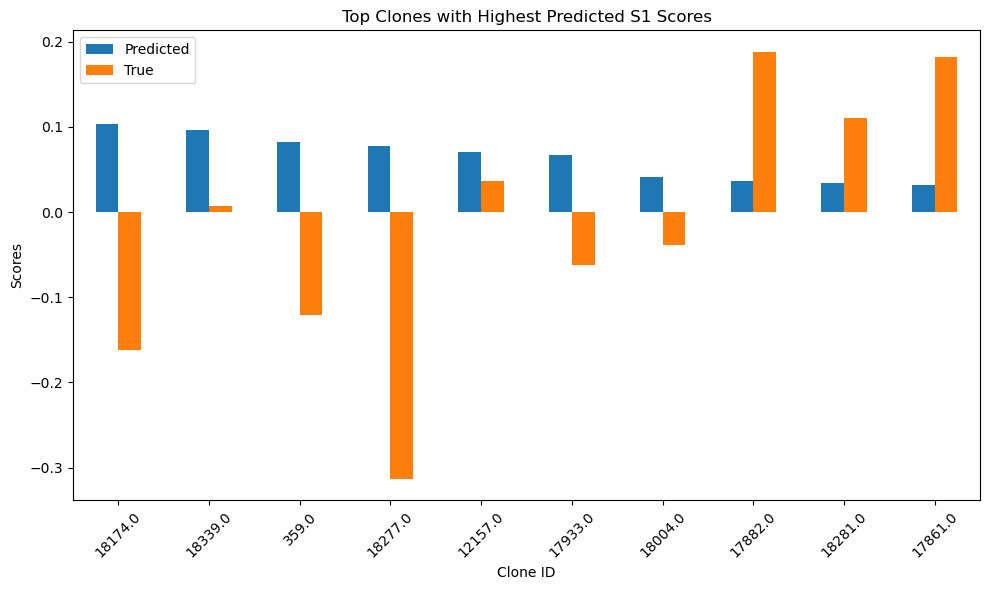

In [29]:
import matplotlib.pyplot as plt

# Bar plot for top clones
top_clones.plot(
    x="Clone_ID",
    y=["Max_Predicted_S1_Score", "Max_True_S1_Score"],
    kind="bar",
    figsize=(10, 6),
    title="Top Clones with Highest Predicted S1 Scores"
)
plt.ylabel("Scores")
plt.xlabel("Clone ID")
plt.xticks(rotation=45)
plt.legend(["Predicted", "True"])
plt.tight_layout()
plt.show()


## Visualize Results

In [ ]:
clonotypes = adata.obs[['clone_id','time']].value_counts().reset_index().pivot(columns='time', index='clone_id', values='count')
clonotypes['sum']=clonotypes.sum(axis=1)
clonotypes = clonotypes.sort_values(by='sum', ascending=False)
clonotypes = clonotypes[(~clonotypes.isna()).sum(axis=1) > 2]

In [ ]:
clonotypes_ifn = clonotypes.iloc[:,0:-1].copy()
for clone in tqdm(clonotypes_ifn.index):
    for time in clonotypes_ifn.columns:
        clonotypes_ifn.loc[clone,time] = adata.obs.loc[(adata.obs.clone_id == clone) & (adata.obs.time == time),'IFN Response_score'].mean()

In [ ]:
clonotypes_ifn['sum'] = clonotypes['sum']

In [ ]:
clones = clonotypes_ifn[(~clonotypes_ifn.T1.isna()) & (clonotypes_ifn['sum'] > 50)].sort_values(by='T1').index
clones = clones[0:5].tolist() + clones[-6:-1].tolist()
dt = adata[adata.obs.clone_id.isin(clones) & (adata.obs.time == 'T1')].obs[['clone_id','IFN Response_score']]
dt.loc[:,['clone response']] = dt['clone_id'].map({clone: ('NR' if i < 5 else 'R') for i, clone in enumerate(clones)})

rcParams['figure.figsize'] = (10, 5)
sns.boxplot(data=dt, x="clone_id", y="IFN Response_score", hue="clone_id", palette='Paired', hue_order=np.array(clones)[[0,5,1,6,2,7,3,8,4,9]], order=clones)
rcParams['figure.figsize'] = (5, 4)

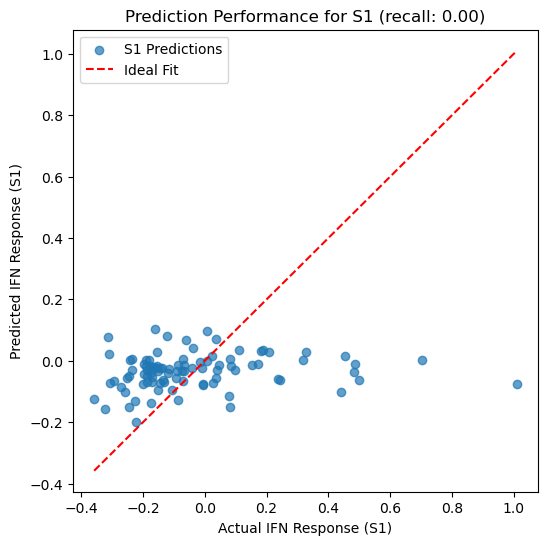

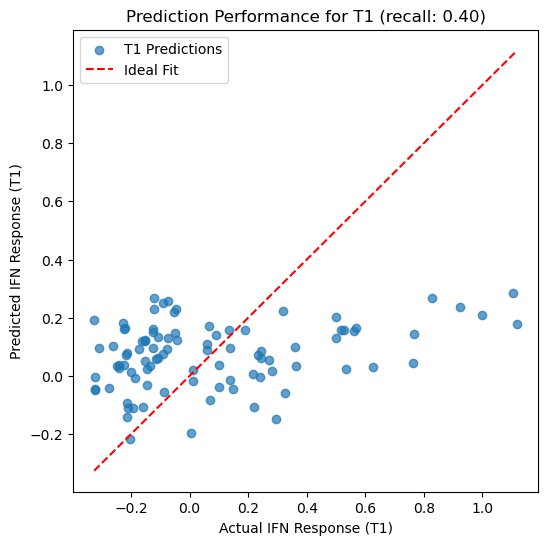

In [75]:
import matplotlib.pyplot as plt

# Visualization for S1
plt.figure(figsize=(6, 6))
plt.scatter(y_s1_test, y_s1_pred, alpha=0.7, label="S1 Predictions")
plt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (S1)")
plt.ylabel("Predicted IFN Response (S1)")
plt.title(f"Prediction Performance for S1 (recall: {recall_ks1:.2f})")
plt.legend()
plt.show()

# Visualization for T1
plt.figure(figsize=(6, 6))
plt.scatter(y_t1_test, y_t1_pred, alpha=0.7, label="T1 Predictions")
plt.plot([y_t1_test.min(), y_t1_test.max()], [y_t1_test.min(), y_t1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (T1)")
plt.ylabel("Predicted IFN Response (T1)")
plt.title(f"Prediction Performance for T1 (recall: {recall_kt1:.2f})")
plt.legend()
plt.show()


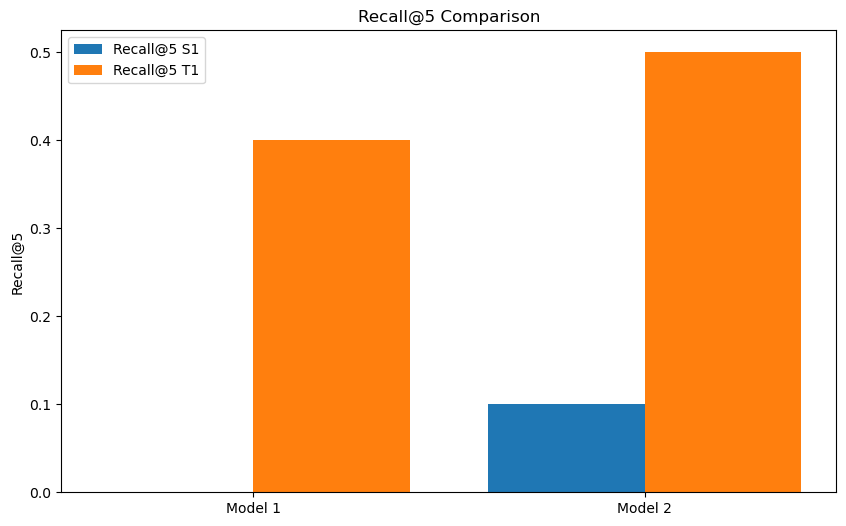

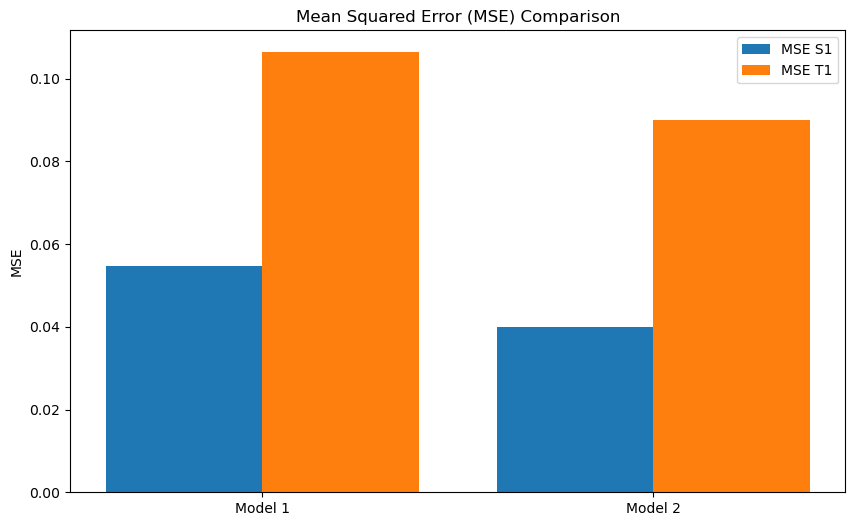

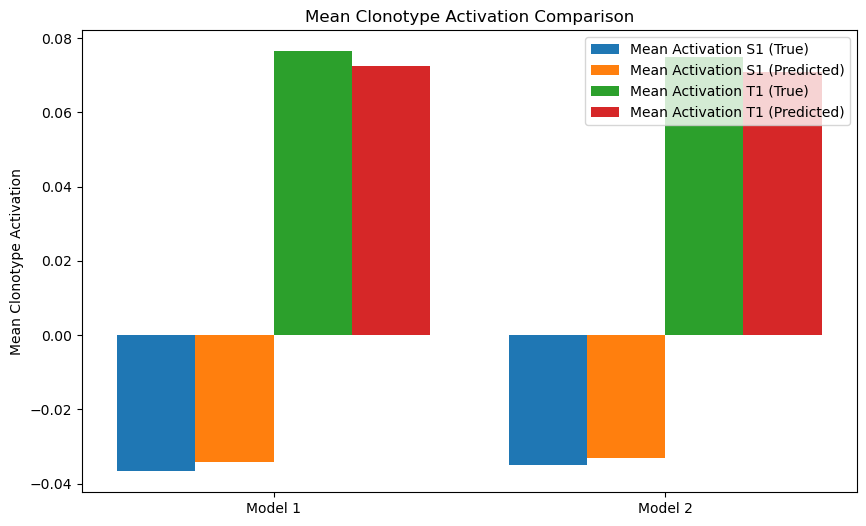

In [57]:
# TODO jsut the concept, add values

# Example metrics for two models
models = ['Model 1', 'Model 2']  # Add more models as needed
recall_s1 = [0.00, 0.10]  # Replace with Recall@5 for S1 across models
recall_t1 = [0.40, 0.50]  # Replace with Recall@5 for T1 across models
mse_s1 = [0.0547, 0.0400]  # Replace with MSE for S1 across models
mse_t1 = [0.1064, 0.0900]  # Replace with MSE for T1 across models
mean_activation_s1 = [-0.0367, -0.0350]  # Replace with Mean Clonotype Activation (True) for S1
mean_activation_s1_pred = [-0.0342, -0.0330]  # Replace with Mean Clonotype Activation (Predicted) for S1
mean_activation_t1 = [0.0765, 0.0750]  # Replace with Mean Clonotype Activation (True) for T1
mean_activation_t1_pred = [0.0724, 0.0710]  # Replace with Mean Clonotype Activation (Predicted) for T1

x = np.arange(len(models))  # X locations for the groups

# Plot Recall@5
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, recall_s1, width=0.4, label='Recall@5 S1')
plt.bar(x + 0.2, recall_t1, width=0.4, label='Recall@5 T1')
plt.xticks(x, models)
plt.ylabel('Recall@5')
plt.title('Recall@5 Comparison')
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, mse_s1, width=0.4, label='MSE S1')
plt.bar(x + 0.2, mse_t1, width=0.4, label='MSE T1')
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.legend()
plt.show()

# Plot Mean Clonotype Activation
plt.figure(figsize=(10, 6))
bar_width = 0.2
plt.bar(x - 0.3, mean_activation_s1, width=bar_width, label='Mean Activation S1 (True)')
plt.bar(x - 0.1, mean_activation_s1_pred, width=bar_width, label='Mean Activation S1 (Predicted)')
plt.bar(x + 0.1, mean_activation_t1, width=bar_width, label='Mean Activation T1 (True)')
plt.bar(x + 0.3, mean_activation_t1_pred, width=bar_width, label='Mean Activation T1 (Predicted)')
plt.xticks(x, models)
plt.ylabel('Mean Clonotype Activation')
plt.title('Mean Clonotype Activation Comparison')
plt.legend()
plt.show()


# Tune Parameters 

In [118]:
params = {
    "n_estimators": 100, 
    "learning_rate": 0.1, 
    "max_depth": 3, 
    "random_state": 42,
    'device': 'mps'
}

In [122]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

# Define parameter distribution
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', 'log2', None]
} # TODO do these parameters make sense?

# Initialize GradientBoostingRegressor
gbr = GradientBoostingRegressor()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

"""
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)
"""

# Fit the model
random_search.fit(X_s1_train, y_s1_train)

# Output the best parameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'learning_rate': 0.010518486277398677, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 57, 'subsample': 0.910590063177311}
Best score: 0.04978820416179372


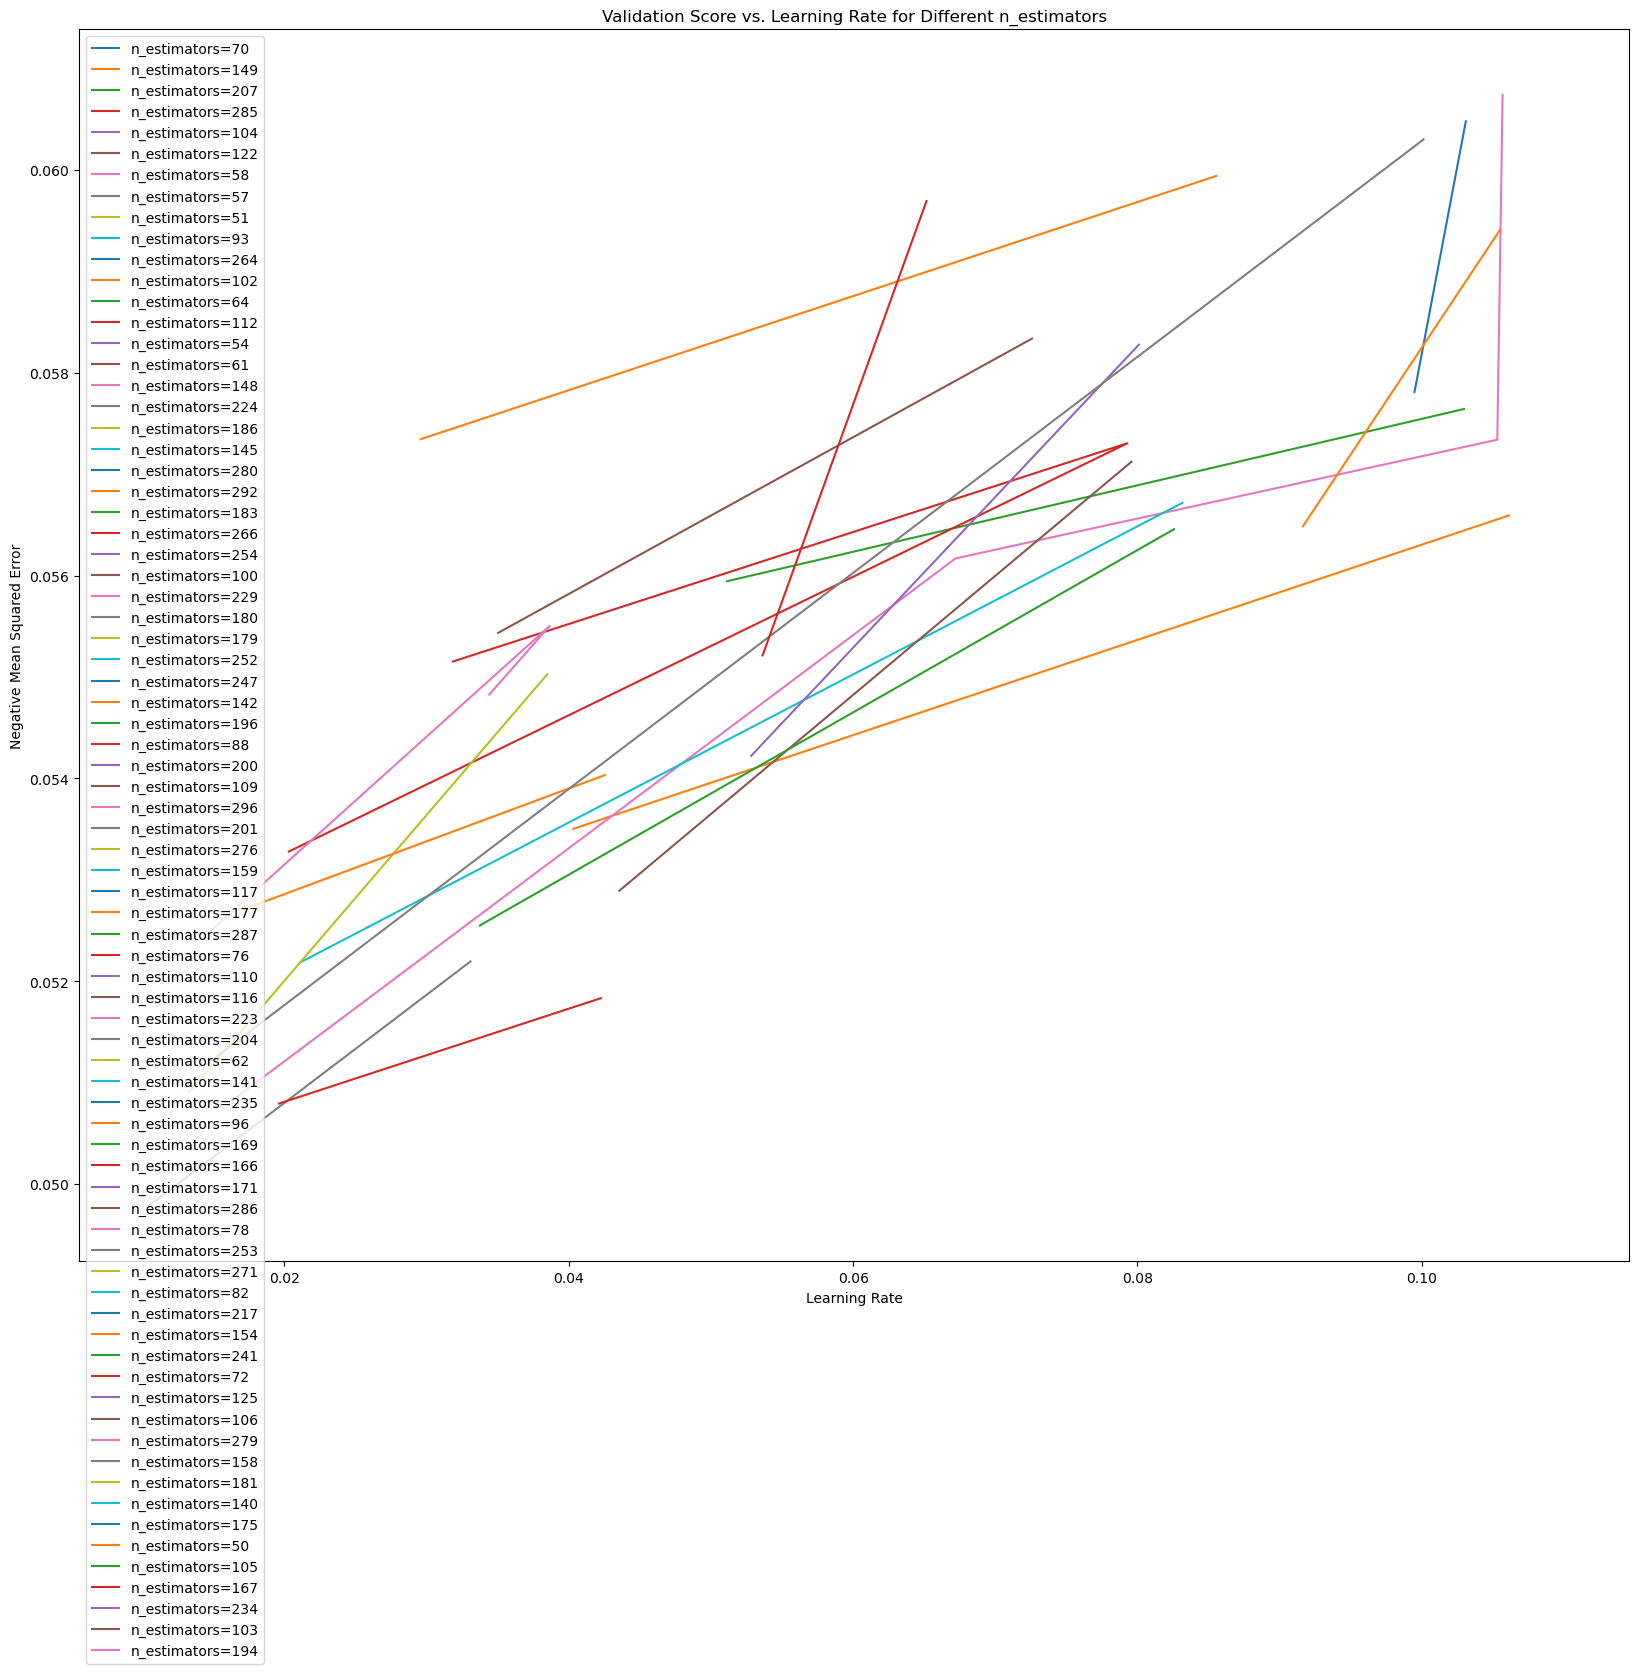

In [126]:
#Plotting param tunign results
results = pd.DataFrame(random_search.cv_results_)

# Example: Visualizing validation score for different learning rates
plt.figure(figsize=(20, 16))
for n_estimators in results['param_n_estimators'].unique():
    subset = results[results['param_n_estimators'] == n_estimators]
    plt.plot(subset['param_learning_rate'], -subset['mean_test_score'], label=f'n_estimators={n_estimators}')

plt.xlabel('Learning Rate')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Score vs. Learning Rate for Different n_estimators')
plt.legend()
plt.show()

# Using Pytorch

In [112]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import shutil


## Convert Dataframes to Tensors

In [132]:
# Convert data to PyTorch tensors
X_s1_train_tensor = torch.tensor(X_s1_train, dtype=torch.float32)
y_s1_train_tensor = torch.tensor(y_s1_train, dtype=torch.float32).unsqueeze(1)  # Add a dimension for output
X_s1_test_tensor = torch.tensor(X_s1_test, dtype=torch.float32)
y_s1_test_tensor = torch.tensor(y_s1_test, dtype=torch.float32).unsqueeze(1)

X_t1_train_tensor = torch.tensor(X_t1_train, dtype=torch.float32)
y_t1_train_tensor = torch.tensor(y_t1_train, dtype=torch.float32).unsqueeze(1)
X_t1_test_tensor = torch.tensor(X_t1_test, dtype=torch.float32)
y_t1_test_tensor = torch.tensor(y_t1_test, dtype=torch.float32).unsqueeze(1)

In [133]:
device = torch.device('mps')

In [134]:
# Setting up Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/simple_nn")

## Initializing a simple NN

In [135]:
# setup NN
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [136]:
# Initialize models
input_size = X_s1_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Single output (regression)

# Models for S1 and T1
model_s1 = SimpleNN(input_size, hidden_size, output_size)
model_t1 = SimpleNN(input_size, hidden_size, output_size)

In [137]:
## Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=0.001)
optimizer_t1 = optim.Adam(model_t1.parameters(), lr=0.001)


## Train

In [138]:
def train_model(X_train, y_train, X_test, y_test, input_size, hidden_size, lr, num_epochs=50):
    # Define the model
    model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor).item()

    return test_loss

In [141]:
# old Training code 
num_epochs = 100

# Training loop for S1
for epoch in range(num_epochs):
    # Forward pass
    outputs = model_s1(X_s1_train_tensor)
    loss = criterion(outputs, y_s1_train_tensor)

    # Backward pass and optimization
    optimizer_s1.zero_grad()
    loss.backward()
    optimizer_s1.step()

    # Log training loss
    writer.add_scalar("Loss/Train_S1", loss.item(), epoch)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Close the writer when done
writer.close()


# Training loop for T1
for epoch in range(num_epochs):
    # Forward pass for T1
    model_t1.train()
    outputs = model_t1(X_t1_train_tensor)
    loss = criterion(outputs, y_t1_train_tensor)
    
    # Backward pass and optimization
    optimizer_t1.zero_grad()
    loss.backward()
    optimizer_t1.step()

    # Log training loss
    writer.add_scalar("Loss/Train_T1", loss.item(), epoch)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss (T1): {loss.item():.4f}')


Epoch [10/100], Loss: 0.0291
Epoch [20/100], Loss: 0.0278
Epoch [30/100], Loss: 0.0265
Epoch [40/100], Loss: 0.0253
Epoch [50/100], Loss: 0.0242
Epoch [60/100], Loss: 0.0231
Epoch [70/100], Loss: 0.0221
Epoch [80/100], Loss: 0.0211
Epoch [90/100], Loss: 0.0202
Epoch [100/100], Loss: 0.0193
Epoch [10/100], Loss (T1): 0.0648
Epoch [20/100], Loss (T1): 0.0618
Epoch [30/100], Loss (T1): 0.0591
Epoch [40/100], Loss (T1): 0.0565
Epoch [50/100], Loss (T1): 0.0540
Epoch [60/100], Loss (T1): 0.0517
Epoch [70/100], Loss (T1): 0.0495
Epoch [80/100], Loss (T1): 0.0474
Epoch [90/100], Loss (T1): 0.0453
Epoch [100/100], Loss (T1): 0.0433


## Param Tune

In [140]:
import random

# Define hyperparameter ranges
hidden_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
num_samples = 10

# Random search
best_params = None
best_loss = float('inf')

for _ in range(num_samples):
    hidden_size = random.choice(hidden_sizes)
    lr = random.choice(learning_rates)
    test_loss = train_model(
        X_train=X_s1_train,
        y_train=y_s1_train,
        X_test=X_s1_test,
        y_test=y_s1_test,
        input_size=X_s1_train.shape[1],
        hidden_size=hidden_size,
        lr=lr,
        num_epochs=num_epochs,
    )
    print(f"Hidden Size: {hidden_size}, Learning Rate: {lr}, Test Loss: {test_loss:.4f}")
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = {"hidden_size": hidden_size, "lr": lr}

print(f"Best Params: {best_params}, Best Loss: {best_loss:.4f}")

Hidden Size: 32, Learning Rate: 0.001, Test Loss: 0.0442
Hidden Size: 32, Learning Rate: 0.01, Test Loss: 0.0580
Hidden Size: 32, Learning Rate: 0.001, Test Loss: 0.0455
Hidden Size: 128, Learning Rate: 0.01, Test Loss: 0.0686
Hidden Size: 64, Learning Rate: 0.01, Test Loss: 0.0826
Hidden Size: 32, Learning Rate: 0.0001, Test Loss: 0.0735
Hidden Size: 64, Learning Rate: 0.0001, Test Loss: 0.0489
Hidden Size: 64, Learning Rate: 0.01, Test Loss: 0.0783
Hidden Size: 64, Learning Rate: 0.0001, Test Loss: 0.0535
Hidden Size: 64, Learning Rate: 0.001, Test Loss: 0.0553
Best Params: {'hidden_size': 32, 'lr': 0.001}, Best Loss: 0.0442


In [37]:
best_hidden_size = best_params["hidden_size"]
best_lr = best_params["lr"]

final_loss = train_model(
    X_train=X_s1_train,
    y_train=y_s1_train,
    X_test=X_s1_test,
    y_test=y_s1_test,
    input_size=X_s1_train.shape[1],
    hidden_size=best_hidden_size,
    lr=best_lr,
    num_epochs=100,  # Use more epochs for final training
)

print(f"Final Test Loss: {final_loss:.4f}")

Final Test Loss: 0.0576


Starting tensorboard from terminal:

tensorboard --logdir=runs

## Eval

In [142]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Evaluate S1 model
model_s1.eval()
with torch.no_grad():
    y_s1_pred = model_s1(X_s1_test_tensor).squeeze()  # Remove extra dimension
    s1_test_loss = criterion(y_s1_pred, y_s1_test_tensor).item()  # MSE loss

    # Convert predictions and targets to NumPy
    y_s1_pred_np = y_s1_pred.numpy()
    y_s1_test_np = y_s1_test_tensor.squeeze().numpy()

    # MSE
    mse_s1 = mean_squared_error(y_s1_test_np, y_s1_pred_np)

    # Mean clonotype activation
    mean_activation_s1 = np.mean(y_s1_pred_np)
    real_activation_s1 = np.mean(y_s1_test_np)

    # Recall @ k (e.g., k = 5)
    k = 5
    top_k_true = np.argsort(y_s1_test_np)[-k:]  # Indices of top k true activations
    top_k_pred = np.argsort(y_s1_pred_np)[-k:]  # Indices of top k predicted activations
    recall_at_k_s1 = len(set(top_k_true) & set(top_k_pred)) / len(top_k_true)

print(f'S1 Metrics:')
print(f'  MSE: {s1_test_loss:.4f}')
print(f'  Mean Activation: {real_activation_s1:.4f}')
print(f'  Mean Activation Pred: {mean_activation_s1:.4f}')
print(f'  Recall @ {k}: {recall_at_k_s1:.4f}')

# Evaluate T1 model
model_t1.eval()
with torch.no_grad():
    y_t1_pred = model_t1(X_t1_test_tensor).squeeze()
    t1_test_loss = criterion(y_t1_pred, y_t1_test_tensor).item()

    # Convert predictions and targets to NumPy
    y_t1_pred_np = y_t1_pred.numpy()
    y_t1_test_np = y_t1_test_tensor.squeeze().numpy()

    # MSE
    mse_t1 = mean_squared_error(y_t1_test_np, y_t1_pred_np)

    # Mean clonotype activation
    mean_activation_t1 = np.mean(y_t1_pred_np)
    real_activation_t1 = np.mean(y_t1_test_np)

    # Recall @ k (e.g., k = 5)
    top_k_true = np.argsort(y_t1_test_np)[-k:]
    top_k_pred = np.argsort(y_t1_pred_np)[-k:]
    recall_at_k_t1 = len(set(top_k_true) & set(top_k_pred)) / len(top_k_true)

print(f'T1 Metrics:')
print(f'  MSE: {t1_test_loss:.4f}')
print(f'  Mean Activation: {real_activation_t1:.4f}')
print(f'  Mean Activation Pred: {mean_activation_t1:.4f}')
print(f'  Recall @ {k}: {recall_at_k_t1:.4f}')



S1 Metrics:
  MSE: 0.0648
  Mean Activation: -0.0941
  Mean Activation Pred: -0.0373
  Recall @ 5: 0.2000
T1 Metrics:
  MSE: 0.1445
  Mean Activation: 0.0530
  Mean Activation Pred: 0.0654
  Recall @ 5: 0.2000


# Visualizations of all Models for Presentation (Hardcoded)

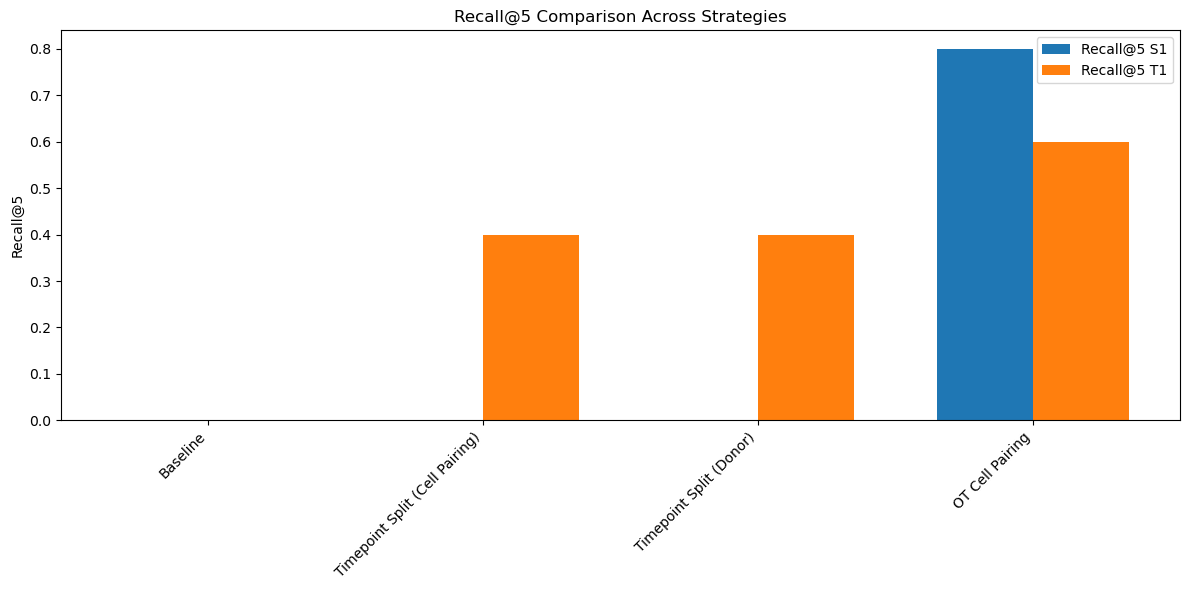

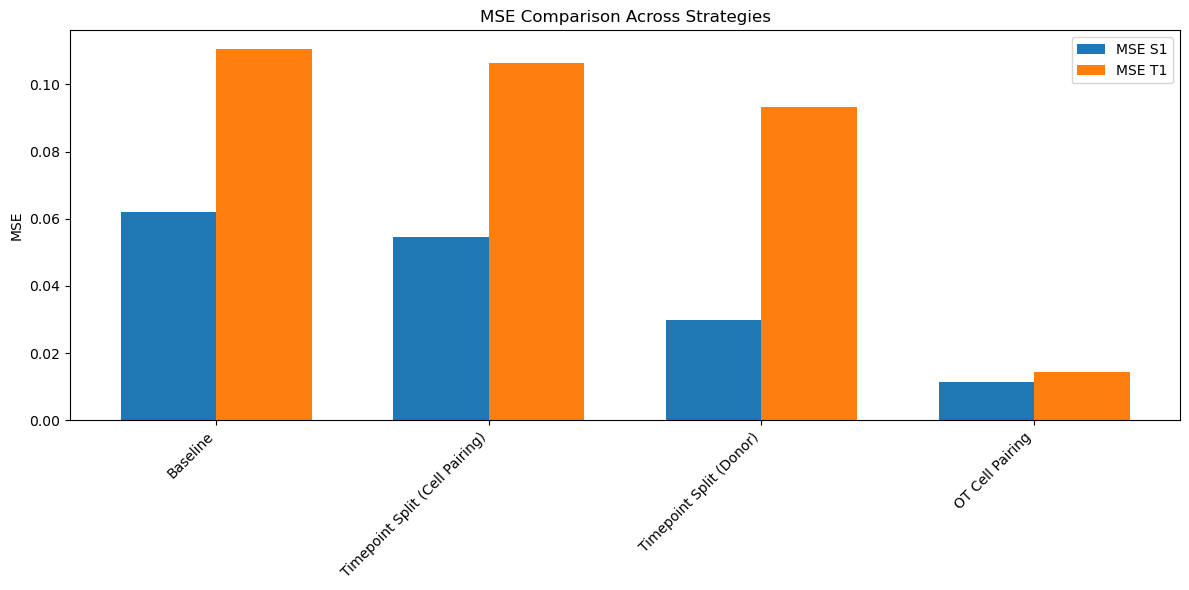

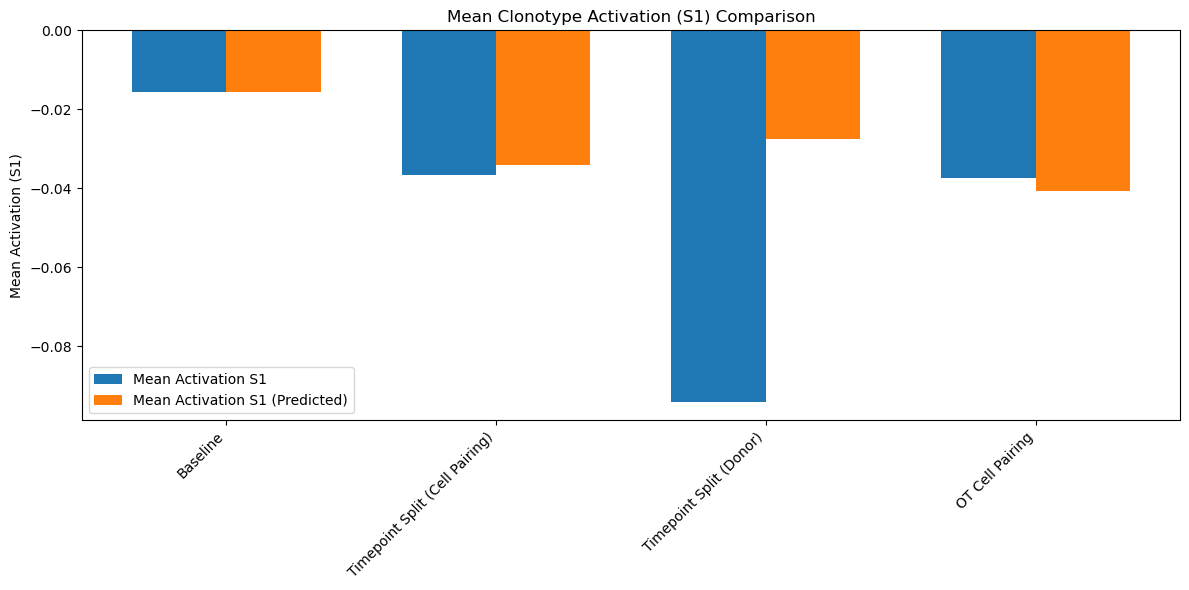

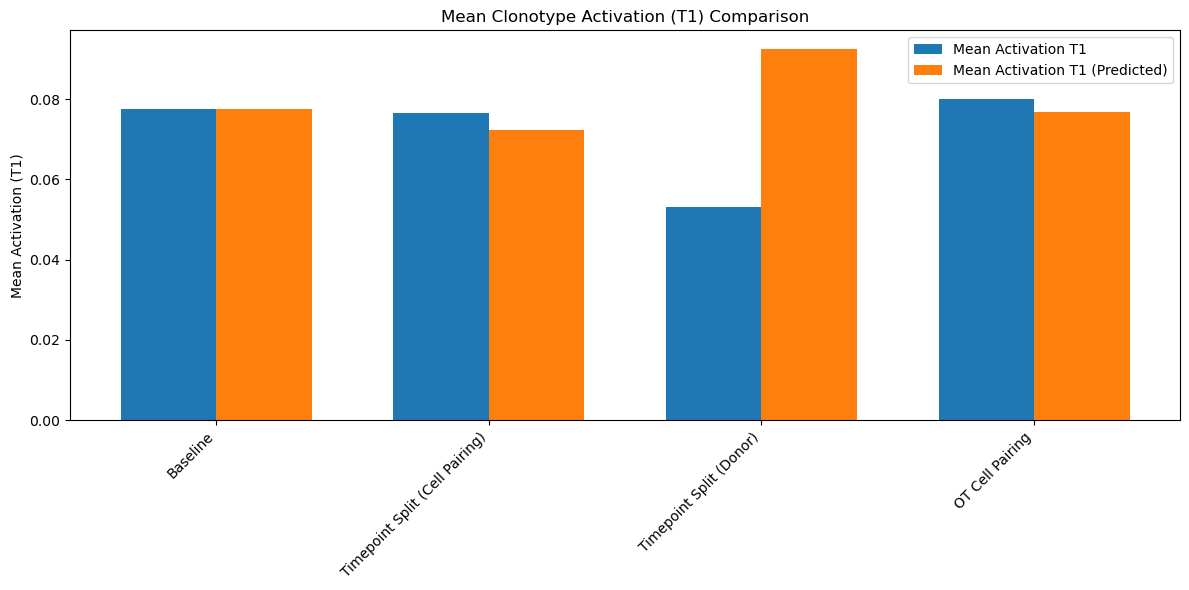

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Data
strategies = [
    "Baseline", 
    "Timepoint Split (Cell Pairing)", 
    "Timepoint Split (Donor)", 
    "OT Cell Pairing"
]
models = ["LinReg", "Grad Boosting", "NN"]

# Metrics for S1 and T1
recall_s1 = [0.00, 0.00, 0.00, 0.80]
recall_t1 = [0.00, 0.40, 0.40, 0.60]

mse_s1 = [0.0621, 0.0547, 0.0299, 0.0114]
mse_t1 = [0.1106, 0.1064, 0.0933, 0.0143]

mean_s1 = [-0.0155, -0.0367, -0.0941, -0.0373]
mean_pred_s1 = [-0.0155, -0.0342, -0.0276, -0.0408]

mean_t1 = [0.0776, 0.0765, 0.0530, 0.0799]
mean_pred_t1 = [0.0776, 0.0724, 0.0925, 0.0767]

# Create a grouped bar plot for Recall@5
x = np.arange(len(strategies))  # Position of groups

plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(x - bar_width/2, recall_s1, width=bar_width, label="Recall@5 S1")
plt.bar(x + bar_width/2, recall_t1, width=bar_width, label="Recall@5 T1")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Recall@5")
plt.title("Recall@5 Comparison Across Strategies")
plt.legend()
plt.tight_layout()
plt.show()

# Create a grouped bar plot for MSE
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, mse_s1, width=bar_width, label="MSE S1")
plt.bar(x + bar_width/2, mse_t1, width=bar_width, label="MSE T1")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("MSE")
plt.title("MSE Comparison Across Strategies")
plt.legend()
plt.tight_layout()
plt.show()

# Create a grouped bar plot for Mean Clonotype Activation
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, mean_s1, width=bar_width, label="Mean Activation S1")
plt.bar(x + bar_width/2, mean_pred_s1, width=bar_width, label="Mean Activation S1 (Predicted)")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Mean Activation (S1)")
plt.title("Mean Clonotype Activation (S1) Comparison")
plt.legend()
plt.tight_layout()
plt.show()


# Create a grouped bar plot for Mean Clonotype Activation
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, mean_t1, width=bar_width, label="Mean Activation T1")
plt.bar(x + bar_width/2, mean_pred_t1, width=bar_width, label="Mean Activation T1 (Predicted)")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Mean Activation (T1)")
plt.title("Mean Clonotype Activation (T1) Comparison")
plt.legend()
plt.tight_layout()
plt.show()


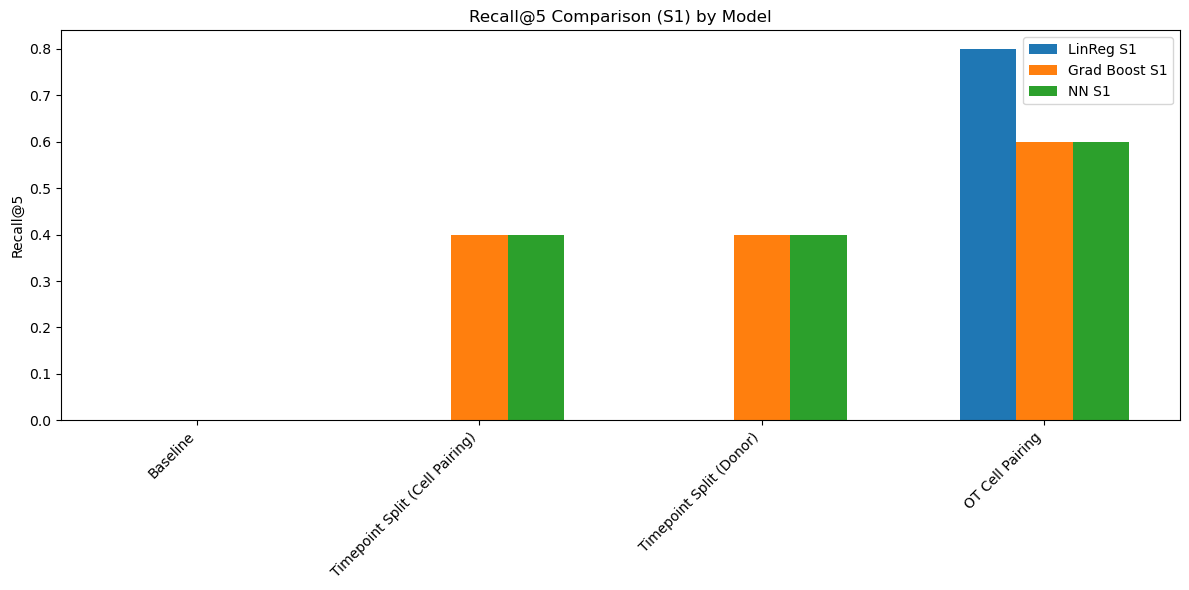

In [144]:
# TODO correct?????
# Stacked Bar Plot Example for Recall@5
plt.figure(figsize=(12, 6))
bar_width = 0.2

x = np.arange(len(strategies))

# Plot Recall for each model
plt.bar(x - bar_width, recall_s1, width=bar_width, label="LinReg S1")
plt.bar(x, recall_t1, width=bar_width, label="Grad Boost S1")
plt.bar(x + bar_width, recall_t1, width=bar_width, label="NN S1")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Recall@5")
plt.title("Recall@5 Comparison (S1) by Model")
plt.legend()
plt.tight_layout()
plt.show()